# INPUT

## input from xls

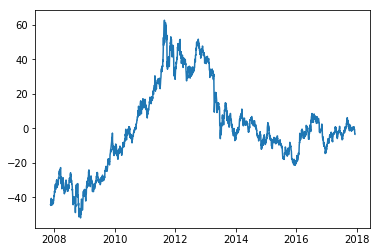

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df

GLD = pd.read_excel('data_GVZ_GLD.xlsx')
date_GLD = GLD.iloc[:,3]
GLD = GLD.loc[:,'GLD']
GLD_d = GLD - np.mean(GLD)
kbar = 5
plt.plot(date_GLD,GLD_d)
data = GLD_d

input_param = [50, 1.99,0.945585657754, 5]

# TEST My own function

## - T_mat_temp 


In [3]:
def T_mat_temp(kbar):
    A = np.fromfunction(lambda i, j: i ^ j, (2**kbar, 2**kbar), dtype=int)
    A_template = A
    return A_template

## MSM_starting_values

In [4]:
def MSM_starting_values(data,startingvals,kbar,A_template):
    # options=optimset('fminbnd');
    xtol = 1e-3
    LLs = []
    output_parameters=[]
    
    # implicit  booleanness of the empty list is quite pythonic.
    if not startingvals:
        print('No starting values entered: Using grid-search')
        # A grid search used to find the best set of starting values in the
        # event none are supplied by the user
        b = [1.5, 3, 6, 20]
        lb = len(b)
        g = [.1, .5, .9]
        lg = len(g)
        sigma = np.std(data)*np.sqrt(252)
        output_parameters=np.zeros((lb*lg,3))
        LLs=zeros((lb*lg,1))
        m0_lower = 1.2
        m0_upper = 1.8
        
        index = 1
        
        for i in range(0,lb):
            for j in range(0,lg):
                
    
## ติดค้างก่อย
function [startingvals,LLs,output_parameters] =...
    
                temp_in = [b(i);1.5;g(j);sigma];
                [m0,LL]=fminbnd('MSM_likelihood',m0_lower,m0_upper,options,kbar,data,A_template,[b(i);g(j);sigma]);
                parameters=[b(i);g(j);m0];
                output_parameters(index,:)=parameters';
                LLs(index)=LL;
                index=index+1;
            end
    end
    [LLs,index]=sort(LLs);
    startingvals=[output_parameters(index(1),:),sigma]';
    output_parameters=output_parameters(index,:);
end

IndentationError: expected an indented block (<ipython-input-4-c8ea5f34c5dc>, line 29)

## MSM_likelihood 

output form matlab using demean GLD

[parameters,LL,exitflag,output]=fmincon('MSM_likelihood',startingvals,...
    [],[],[],[],LB,UB,[],options,kbar,data,A_template);
   
   param = [50,1.99,0.945585657754,5]
   LL = 56886.6637963524
   exitflag = 4
   output = 
   
  [LL,LLs] = MSM_likelihood(parameters,kbar,data,A_template);
  LL = 56886.6637963524
  LLs = 


In [5]:
def MSM_likelihood(input_param, kbar, data, A_template, estim_flag):
    if len(input_param) == 1:
        input_param = [estim_flag[0], input_param, estim_flag[1], estim_flag[2]]

    sigma = input_param[3] / np.sqrt(252)
    k2 = 2 ** kbar

    A = transition_mat(A_template, input_param, kbar)
    g_m = gofm(input_param, kbar)
    T = len(data)
    pi_mat = np.zeros((T + 1, k2))
    LLs = zeros(1, T)
    pi_mat[0, :] = (1 / k2) * np.ones((1, k2))

    # Likelihood Algorithm

    pa = (2 * np.pi) ** (-0.5)
    s = np.matlib.repmat(sigma * g_m, T, 1)
    w_t = np.matlib.repmat(data, 1, k2)
    w_t = np.divide(pa * np.e ** (-0.5 * np.power(np.divide(w_t, s), 2)), s)
    w_t = w_t + 10 ** -16

    for t in range(0, T):
        piA = np.matmul(pi_mat[t, :], A)
        C = np.multiply(w_t[t, :], piA)
        ft = sum(C)

        # stop div by zero if prob are too low
        if ft == 0:
            pi_mat[t + 1, 0] = 1
        else:
            pi_mat[t + 1, :] = np.divide(C, ft)

        LLs[t] = np.log(np.dot(w_t[t, :], piA))

    LL = sum[LLs]

    if np.isinf(LL):
        print('Log-likelihood is inf. Probably due to all zeros in pi_mat.')

    return LL, LLs



### - transition_mat


Calculate transition matric using template


$$ \gamma_{k}=1-(1-\gamma_{1})^{(b^{k-1})} $$

<font color = red>equation (3.2) [Page 21 in MSM book]</font>

In [6]:
def transition_mat(A,input_param,kbar):
    b = input_param[0]
    gamma_kbar = input_param[2]

    gamma = np.zeros((kbar,1))
    gamma[0]=1-(1-gamma_kbar)**(1/(b**(kbar-1))) #TOWARN : Equation does not conform bbut math is ok 

    def bitget(number,position):
    
        bi_number = bin(number)
        bi_number = bi_number[2:]
        if len(bi_number) >= position :
        
            fn_output = bi_number[-position]
        else :
            fn_output = 0
        
        return fn_output

    for i in range(1,kbar):
        gamma[i,0]= 1-(1-gamma[0])**(b**i)

    gamma = gamma/2
    gamma = np.append(gamma,gamma,axis=1)
    gamma[:,0]=1-gamma[:,0]
    
    kbar1 = kbar+1
    kbar2 = 2**kbar

    prob = np.ones((kbar2,1))

    for i in range(0,kbar2):
        for m in range(1,kbar+1):
            prob[i,0]=prob[i,0]*gamma[kbar1-m-1, int(bitget(i,m))]
    
    for i in range(0,2**(kbar-1)):
        for j in range(i,2**(kbar-1)):
            
            A[kbar2-i-1,j] = prob[kbar2-int(A[i,j])-1,0]
            A[kbar2-j-1,i] = A[kbar2-i-1,j]
            A[j,kbar2-i-1] = A[kbar2-i-1,j]
            A[i,kbar2-j-1] = A[kbar2-i-1,j]
            
            A[i,j] = prob[int(A[i,j]),0]
            A[j,i] = A[i,j]
            A[kbar2-i-1,kbar2-j-1] = A[i,j]
            A[kbar2-j-1,kbar2-i-1] = A[i,j]
    return A

### - gofm

In [7]:
def gofm(input_param, kbar):
    m0 = input_param[1]
    m1 = 2-m0
    kbar2 = 2**kbar
    g_m1 = list(range(0,kbar2))
    for i in range(0,kbar2): 
        g = 1
        for j in range(0,kbar): #not req -1
            if g_m1[i]&2**j != 0:
                g = g*m1
            else :
                g=g*m0
        g_m1[i]=g
    
    g_m = np.sqrt(g_m1)
    return g_m

In [71]:
# f=lambda x: x*2
# L=list(map(f,g_m1))

# # TODO: use Lambda function Reduce

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98,
 100,
 102,
 104,
 106,
 108,
 110,
 112,
 114,
 116,
 118,
 120,
 122,
 124,
 126,
 128,
 130,
 132,
 134,
 136,
 138,
 140,
 142,
 144,
 146,
 148,
 150,
 152,
 154,
 156,
 158,
 160,
 162,
 164,
 166,
 168,
 170,
 172,
 174,
 176,
 178,
 180,
 182,
 184,
 186,
 188,
 190,
 192,
 194,
 196,
 198,
 200,
 202,
 204,
 206,
 208,
 210,
 212,
 214,
 216,
 218,
 220,
 222,
 224,
 226,
 228,
 230,
 232,
 234,
 236,
 238,
 240,
 242,
 244,
 246,
 248,
 250,
 252,
 254,
 256,
 258,
 260,
 262,
 264,
 266,
 268,
 270,
 272,
 274,
 276,
 278,
 280,
 282,
 284,
 286,
 288,
 290,
 292,
 294,
 296,
 298,
 300,
 302,
 304,
 306,
 308,
 310,
 312,
 314,
 316,
 318,
 320,
 322,
 324,
 326,
 328,
 330,
 332,
 334,
 336,
 338,
 340,
 342,
 344,
 346,
 348,
 350,

# TEST full

In [10]:
estim_flag = []
A_template = T_mat_temp(kbar)
LL, LLs = MSM_likelihood(input_param, kbar, data, A_template, estim_flag)

NameError: name 'A' is not defined

# TEST part

## OPTIMIZOR

### fminbnd 

* [scipy ref](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fminbound.html)

### fmincon 
This has various issues due to the typr of problems as [This link](https://stackoverflow.com/questions/49926/open-source-alternative-to-matlabs-fmincon-function).

- [stack overflow scipy minimize](https://stackoverflow.com/questions/27851087/matrix-constraints-with-scipy-optimize-minimize)
- [scipy ref](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

In [67]:
df_A = df(A)
df_A.to_excel('transition_mat2.xlsx')

#### - Test gamma

In [49]:
gamma_kbar = input_param[2]

gamma = np.zeros((kbar,1))
gamma[0]=1-(1-gamma_kbar)**(1/(b**(kbar-1))) #TOWARN : Equation does not conform bbut math is ok 

for i in range(1,kbar):
    gamma[i,0]= 1-(1-gamma[0])**(b**i)

gamma = gamma/2
gamma = np.append(gamma,gamma,axis=1)
gamma[:,0]=1-gamma[:,0]

In [50]:
df(gamma)

,0,1
0,0.955052,0.044948
1,0.934117,0.065883
2,0.904506,0.095494
3,0.863833,0.136167
4,0.810361,0.189639
5,0.744521,0.255479
6,0.670998,0.329002
7,0.600000,0.400000


#### - Test prob

In [51]:
prob = np.ones((kbar2,1))

for i in range(0,kbar2):
    for m in range(1,kbar+1):
        prob[i,0]=prob[i,0]*gamma[kbar1-m-1, int(bitget(i,m))]
print(prob)

[[  1.69315661e-01]
 [  1.12877107e-01]
 [  8.30185683e-02]
 [  5.53457122e-02]
 [  5.80998131e-02]
 [  3.87332087e-02]
 [  2.84874020e-02]
 [  1.89916014e-02]
 [  3.96227820e-02]
 [  2.64151880e-02]
 [  1.94277755e-02]
 [  1.29518503e-02]
 [  1.35963574e-02]
 [  9.06423824e-03]
 [  6.66654294e-03]
 [  4.44436196e-03]
 [  2.66894686e-02]
 [  1.77929790e-02]
 [  1.30863351e-02]
 [  8.72422338e-03]
 [  9.15835621e-03]
 [  6.10557081e-03]
 [  4.49050972e-03]
 [  2.99367315e-03]
 [  6.24579552e-03]
 [  4.16386368e-03]
 [  3.06242789e-03]
 [  2.04161859e-03]
 [  2.14321316e-03]
 [  1.42880877e-03]
 [  1.05085665e-03]
 [  7.00571100e-04]
 [  1.78757231e-02]
 [  1.19171487e-02]
 [  8.76479430e-03]
 [  5.84319620e-03]
 [  6.13396401e-03]
 [  4.08930934e-03]
 [  3.00759486e-03]
 [  2.00506324e-03]
 [  4.18322721e-03]
 [  2.78881814e-03]
 [  2.05111289e-03]
 [  1.36740859e-03]
 [  1.43545327e-03]
 [  9.56968847e-04]
 [  7.03829019e-04]
 [  4.69219346e-04]
 [  2.81777567e-03]
 [  1.87851711e-03]


In [52]:
df_prob = df(prob)
df_prob.to_excel('prob.xlsx')

In [24]:
prob

array([[ 0.00838513],
       [ 0.00838513],
       [ 0.00838513],
       [ 0.00838513],
       [ 0.00838504],
       [ 0.00838504],
       [ 0.00838504],
       [ 0.00838504],
       [ 0.00838028],
       [ 0.00838028],
       [ 0.00838028],
       [ 0.00838028],
       [ 0.00838019],
       [ 0.00838019],
       [ 0.00838019],
       [ 0.00838019],
       [ 0.00831208],
       [ 0.00831208],
       [ 0.00831208],
       [ 0.00831208],
       [ 0.00831199],
       [ 0.00831199],
       [ 0.00831199],
       [ 0.00831199],
       [ 0.00830727],
       [ 0.00830727],
       [ 0.00830727],
       [ 0.00830727],
       [ 0.00830719],
       [ 0.00830719],
       [ 0.00830719],
       [ 0.00830719],
       [ 0.00794822],
       [ 0.00794822],
       [ 0.00794822],
       [ 0.00794822],
       [ 0.00794814],
       [ 0.00794814],
       [ 0.00794814],
       [ 0.00794814],
       [ 0.00794362],
       [ 0.00794362],
       [ 0.00794362],
       [ 0.00794362],
       [ 0.00794354],
       [ 0